##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TF Lattice Premade Models

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lattice/tutorials/premade_models"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/lattice/blob/master/docs/tutorials/premade_models.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/lattice/blob/master/docs/tutorials/premade_models.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/lattice/docs/tutorials/premade_models.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

Premade Models are quick and easy ways to build TFL `keras.Model` instances for typical use cases. This guide outlines the steps needed to construct a TFL Premade Model and train/test it.

## Setup

Installing TF Lattice package:

In [2]:
#@test {"skip": true}
!pip install -U tensorflow tf-keras tensorflow-lattice  pydot graphviz

Importing required packages:

In [3]:
import tensorflow as tf

import copy
import logging
import numpy as np
import pandas as pd
import sys
import tensorflow_lattice as tfl
logging.disable(sys.maxsize)

2024-12-15 12:12:42.423075: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734264762.446855   10189 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734264762.454117   10189 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Use Keras 2.
version_fn = getattr(tf.keras, "version", None)
if version_fn and version_fn().startswith("3."):
  import tf_keras as keras
else:
  keras = tf.keras

Setting the default values used for training in this guide:

In [5]:
LEARNING_RATE = 0.01
BATCH_SIZE = 128
NUM_EPOCHS = 500
PREFITTING_NUM_EPOCHS = 10

Downloading the UCI Statlog (Heart) dataset:

In [6]:
heart_csv_file = keras.utils.get_file(
    'heart.csv',
    'http://storage.googleapis.com/download.tensorflow.org/data/heart.csv')
heart_df = pd.read_csv(heart_csv_file)
thal_vocab_list = ['normal', 'fixed', 'reversible']
heart_df['thal'] = heart_df['thal'].map(
    {v: i for i, v in enumerate(thal_vocab_list)})
heart_df = heart_df.astype(float)

heart_train_size = int(len(heart_df) * 0.8)
heart_train_dict = dict(heart_df[:heart_train_size])
heart_test_dict = dict(heart_df[heart_train_size:])

# This ordering of input features should match the feature configs. If no
# feature config relies explicitly on the data (i.e. all are 'quantiles'),
# then you can construct the feature_names list by simply iterating over each
# feature config and extracting it's name.
feature_names = [
    'age', 'sex', 'cp', 'chol', 'fbs', 'trestbps', 'thalach', 'restecg',
    'exang', 'oldpeak', 'slope', 'ca', 'thal'
]

# Since we have some features that manually construct their input keypoints,
# we need an index mapping of the feature names.
feature_name_indices = {name: index for index, name in enumerate(feature_names)}

label_name = 'target'
heart_train_xs = [
    heart_train_dict[feature_name] for feature_name in feature_names
]
heart_test_xs = [heart_test_dict[feature_name] for feature_name in feature_names]
heart_train_ys = heart_train_dict[label_name]
heart_test_ys = heart_test_dict[label_name]

 8192/13273 [=================>............] - ETA: 0s

13273/13273 [==============================] - 0s 0us/step


## Feature Configs

Feature calibration and per-feature configurations are set using [tfl.configs.FeatureConfig](https://www.tensorflow.org/lattice/api_docs/python/tfl/configs/FeatureConfig). Feature configurations include monotonicity constraints, per-feature regularization (see [tfl.configs.RegularizerConfig](https://www.tensorflow.org/lattice/api_docs/python/tfl/configs/RegularizerConfig)), and lattice sizes for lattice models.

Note that we must fully specify the feature config for any feature that we want our model to recognize. Otherwise the model will have no way of knowing that such a feature exists.

### Defining Our Feature Configs

Now that we can compute our quantiles, we define a feature config for each feature that we want our model to take as input.

In [7]:
# Features:
# - age
# - sex
# - cp        chest pain type (4 values)
# - trestbps  resting blood pressure
# - chol      serum cholestoral in mg/dl
# - fbs       fasting blood sugar > 120 mg/dl
# - restecg   resting electrocardiographic results (values 0,1,2)
# - thalach   maximum heart rate achieved
# - exang     exercise induced angina
# - oldpeak   ST depression induced by exercise relative to rest
# - slope     the slope of the peak exercise ST segment
# - ca        number of major vessels (0-3) colored by flourosopy
# - thal      normal; fixed defect; reversable defect
#
# Feature configs are used to specify how each feature is calibrated and used.
heart_feature_configs = [
    tfl.configs.FeatureConfig(
        name='age',
        lattice_size=3,
        monotonicity='increasing',
        # We must set the keypoints manually.
        pwl_calibration_num_keypoints=5,
        pwl_calibration_input_keypoints='quantiles',
        pwl_calibration_clip_max=100,
        # Per feature regularization.
        regularizer_configs=[
            tfl.configs.RegularizerConfig(name='calib_wrinkle', l2=0.1),
        ],
    ),
    tfl.configs.FeatureConfig(
        name='sex',
        num_buckets=2,
    ),
    tfl.configs.FeatureConfig(
        name='cp',
        monotonicity='increasing',
        # Keypoints that are uniformly spaced.
        pwl_calibration_num_keypoints=4,
        pwl_calibration_input_keypoints=np.linspace(
            np.min(heart_train_xs[feature_name_indices['cp']]),
            np.max(heart_train_xs[feature_name_indices['cp']]),
            num=4),
    ),
    tfl.configs.FeatureConfig(
        name='chol',
        monotonicity='increasing',
        # Explicit input keypoints initialization.
        pwl_calibration_input_keypoints=[126.0, 210.0, 247.0, 286.0, 564.0],
        # Calibration can be forced to span the full output range by clamping.
        pwl_calibration_clamp_min=True,
        pwl_calibration_clamp_max=True,
        # Per feature regularization.
        regularizer_configs=[
            tfl.configs.RegularizerConfig(name='calib_hessian', l2=1e-4),
        ],
    ),
    tfl.configs.FeatureConfig(
        name='fbs',
        # Partial monotonicity: output(0) <= output(1)
        monotonicity=[(0, 1)],
        num_buckets=2,
    ),
    tfl.configs.FeatureConfig(
        name='trestbps',
        monotonicity='decreasing',
        pwl_calibration_num_keypoints=5,
        pwl_calibration_input_keypoints='quantiles',
    ),
    tfl.configs.FeatureConfig(
        name='thalach',
        monotonicity='decreasing',
        pwl_calibration_num_keypoints=5,
        pwl_calibration_input_keypoints='quantiles',
    ),
    tfl.configs.FeatureConfig(
        name='restecg',
        # Partial monotonicity: output(0) <= output(1), output(0) <= output(2)
        monotonicity=[(0, 1), (0, 2)],
        num_buckets=3,
    ),
    tfl.configs.FeatureConfig(
        name='exang',
        # Partial monotonicity: output(0) <= output(1)
        monotonicity=[(0, 1)],
        num_buckets=2,
    ),
    tfl.configs.FeatureConfig(
        name='oldpeak',
        monotonicity='increasing',
        pwl_calibration_num_keypoints=5,
        pwl_calibration_input_keypoints='quantiles',
    ),
    tfl.configs.FeatureConfig(
        name='slope',
        # Partial monotonicity: output(0) <= output(1), output(1) <= output(2)
        monotonicity=[(0, 1), (1, 2)],
        num_buckets=3,
    ),
    tfl.configs.FeatureConfig(
        name='ca',
        monotonicity='increasing',
        pwl_calibration_num_keypoints=4,
        pwl_calibration_input_keypoints='quantiles',
    ),
    tfl.configs.FeatureConfig(
        name='thal',
        # Partial monotonicity:
        # output(normal) <= output(fixed)
        # output(normal) <= output(reversible)
        monotonicity=[('normal', 'fixed'), ('normal', 'reversible')],
        num_buckets=3,
        # We must specify the vocabulary list in order to later set the
        # monotonicities since we used names and not indices.
        vocabulary_list=thal_vocab_list,
    ),
]

## Set Monotonicities and Keypoints

Next we need to make sure to properly set the monotonicities for features where we used a custom vocabulary (such as 'thal' above).

In [8]:
tfl.premade_lib.set_categorical_monotonicities(heart_feature_configs)

Finally we can complete our feature configs by calculating and setting the keypoints.

In [9]:
feature_keypoints = tfl.premade_lib.compute_feature_keypoints(
    feature_configs=heart_feature_configs, features=heart_train_dict)
tfl.premade_lib.set_feature_keypoints(
    feature_configs=heart_feature_configs,
    feature_keypoints=feature_keypoints,
    add_missing_feature_configs=False)

## Calibrated Linear Model

To construct a TFL premade model, first construct a model configuration from [tfl.configs](https://www.tensorflow.org/lattice/api_docs/python/tfl/configs). A calibrated linear model is constructed using the [tfl.configs.CalibratedLinearConfig](https://www.tensorflow.org/lattice/api_docs/python/tfl/configs/CalibratedLinearConfig). It applies piecewise-linear and categorical calibration on the input features, followed by a linear combination and an optional output piecewise-linear calibration. When using output calibration or when output bounds are specified, the linear layer will apply weighted averaging on calibrated inputs.

This example creates a calibrated linear model on the first 5 features.

2024-12-15 12:12:45.393030: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


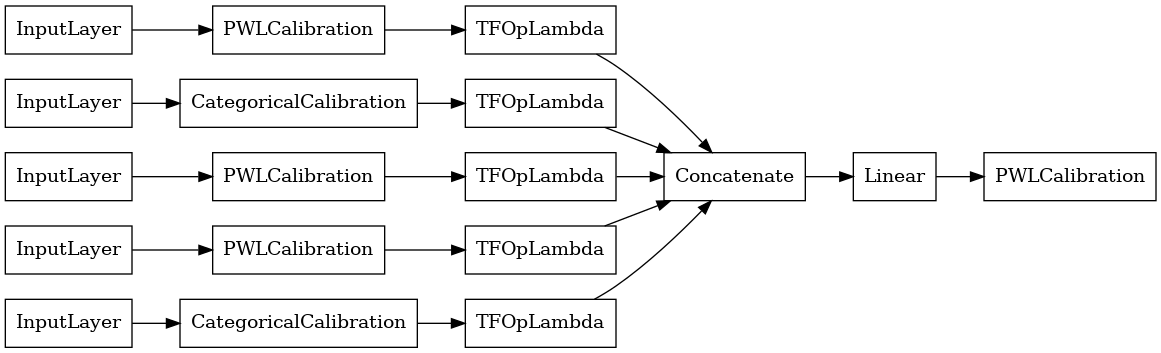

In [10]:
# Model config defines the model structure for the premade model.
linear_model_config = tfl.configs.CalibratedLinearConfig(
    feature_configs=heart_feature_configs[:5],
    use_bias=True,
    output_calibration=True,
    output_calibration_num_keypoints=10,
    # We initialize the output to [-2.0, 2.0] since we'll be using logits.
    output_initialization=np.linspace(-2.0, 2.0, num=10),
    regularizer_configs=[
        # Regularizer for the output calibrator.
        tfl.configs.RegularizerConfig(name='output_calib_hessian', l2=1e-4),
    ])
# A CalibratedLinear premade model constructed from the given model config.
linear_model = tfl.premade.CalibratedLinear(linear_model_config)
# Let's plot our model.
keras.utils.plot_model(linear_model, show_layer_names=False, rankdir='LR')

Now, as with any other [keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model), we compile and fit the model to our data.

In [11]:
linear_model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.AUC(from_logits=True)],
    optimizer=keras.optimizers.Adam(LEARNING_RATE))
linear_model.fit(
    heart_train_xs[:5],
    heart_train_ys,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=False)

After training our model, we can evaluate it on our test set.

In [12]:
print('Test Set Evaluation...')
print(linear_model.evaluate(heart_test_xs[:5], heart_test_ys))

Test Set Evaluation...


1/2 [==============>...............] - ETA: 0s - loss: 0.3853 - auc: 0.7949

2/2 [==============================] - 0s 6ms/step - loss: 0.4779 - auc: 0.8214


[0.47789520025253296, 0.8214285373687744]


## Calibrated Lattice Model

A calibrated lattice model is constructed using [tfl.configs.CalibratedLatticeConfig](https://www.tensorflow.org/lattice/api_docs/python/tfl/configs/CalibratedLatticeConfig). A calibrated lattice model applies piecewise-linear and categorical calibration on the input features, followed by a lattice model and an optional output piecewise-linear calibration.

This example creates a calibrated lattice model on the first 5 features.

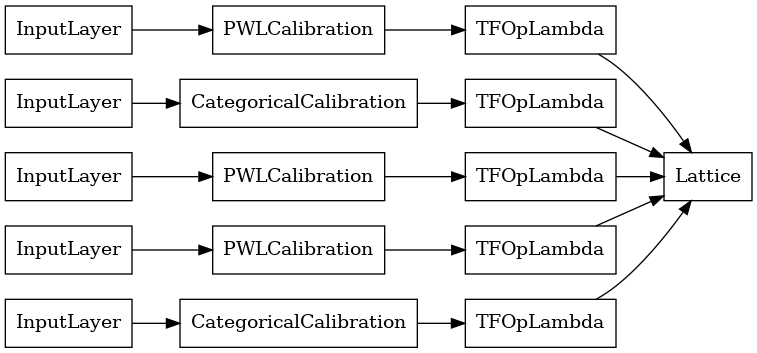

In [13]:
# This is a calibrated lattice model: inputs are calibrated, then combined
# non-linearly using a lattice layer.
lattice_model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=heart_feature_configs[:5],
    # We initialize the output to [-2.0, 2.0] since we'll be using logits.
    output_initialization=[-2.0, 2.0],
    regularizer_configs=[
        # Torsion regularizer applied to the lattice to make it more linear.
        tfl.configs.RegularizerConfig(name='torsion', l2=1e-2),
        # Globally defined calibration regularizer is applied to all features.
        tfl.configs.RegularizerConfig(name='calib_hessian', l2=1e-2),
    ])
# A CalibratedLattice premade model constructed from the given model config.
lattice_model = tfl.premade.CalibratedLattice(lattice_model_config)
# Let's plot our model.
keras.utils.plot_model(lattice_model, show_layer_names=False, rankdir='LR')

As before, we compile, fit, and evaluate our model.

In [14]:
lattice_model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.AUC(from_logits=True)],
    optimizer=keras.optimizers.Adam(LEARNING_RATE))
lattice_model.fit(
    heart_train_xs[:5],
    heart_train_ys,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=False)
print('Test Set Evaluation...')
print(lattice_model.evaluate(heart_test_xs[:5], heart_test_ys))

Test Set Evaluation...


1/2 [==============>...............] - ETA: 0s - loss: 0.3819 - auc_1: 0.8109

2/2 [==============================] - 1s 6ms/step - loss: 0.4728 - auc_1: 0.8308


[0.47279688715934753, 0.8308271169662476]


## Calibrated Lattice Ensemble Model

When the number of features is large, you can use an ensemble model, which creates multiple smaller lattices for subsets of the features and averages their output instead of creating just a single huge lattice. Ensemble lattice models are constructed using [tfl.configs.CalibratedLatticeEnsembleConfig](https://www.tensorflow.org/lattice/api_docs/python/tfl/configs/CalibratedLatticeEnsembleConfig). A calibrated lattice ensemble model applies piecewise-linear and categorical calibration on the input feature, followed by an ensemble of lattice models and an optional output piecewise-linear calibration.

### Explicit Lattice Ensemble Initialization

If you already know which subsets of features you want to feed into your lattices, then you can explicitly set the lattices using feature names. This example creates a calibrated lattice ensemble model with 5 lattices and 3 features per lattice.

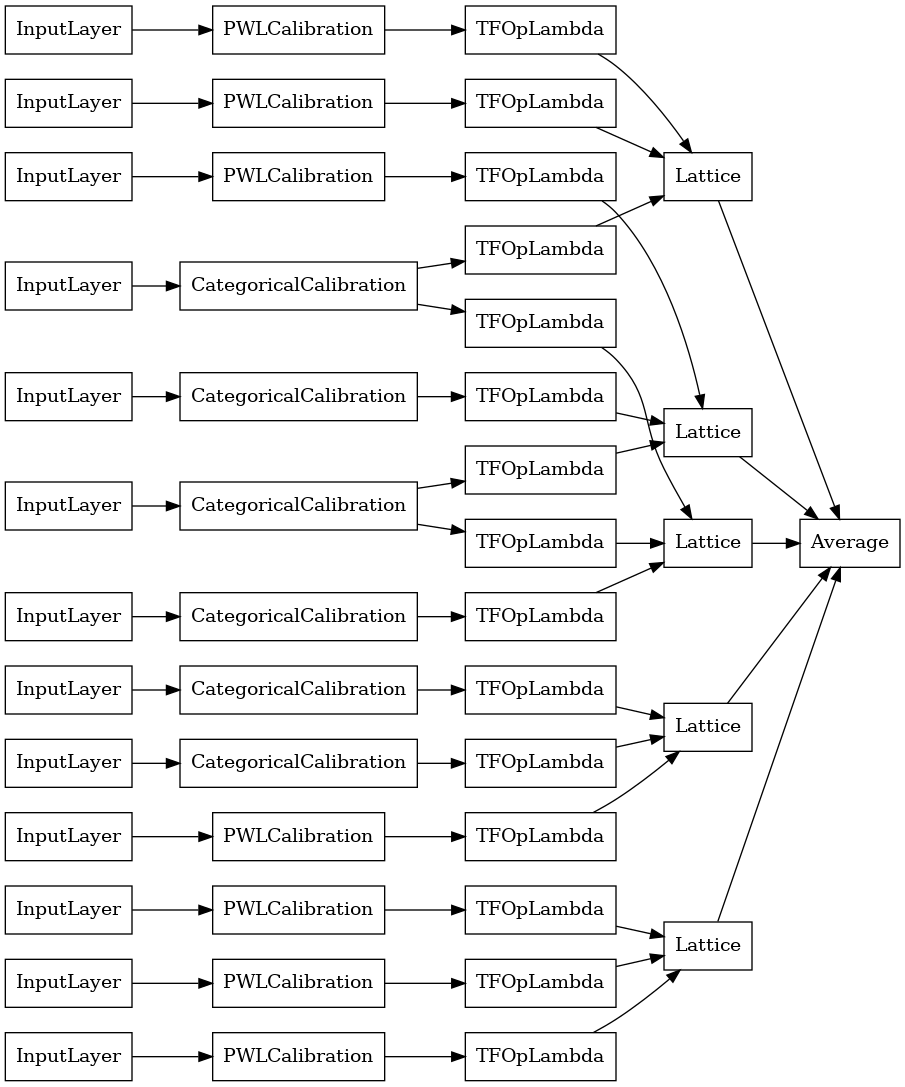

In [15]:
# This is a calibrated lattice ensemble model: inputs are calibrated, then
# combined non-linearly and averaged using multiple lattice layers.
explicit_ensemble_model_config = tfl.configs.CalibratedLatticeEnsembleConfig(
    feature_configs=heart_feature_configs,
    lattices=[['trestbps', 'chol', 'ca'], ['fbs', 'restecg', 'thal'],
              ['fbs', 'cp', 'oldpeak'], ['exang', 'slope', 'thalach'],
              ['restecg', 'age', 'sex']],
    num_lattices=5,
    lattice_rank=3,
    # We initialize the output to [-2.0, 2.0] since we'll be using logits.
    output_initialization=[-2.0, 2.0])
# A CalibratedLatticeEnsemble premade model constructed from the given
# model config.
explicit_ensemble_model = tfl.premade.CalibratedLatticeEnsemble(
    explicit_ensemble_model_config)
# Let's plot our model.
keras.utils.plot_model(
    explicit_ensemble_model, show_layer_names=False, rankdir='LR')

As before, we compile, fit, and evaluate our model.

In [16]:
explicit_ensemble_model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.AUC(from_logits=True)],
    optimizer=keras.optimizers.Adam(LEARNING_RATE))
explicit_ensemble_model.fit(
    heart_train_xs,
    heart_train_ys,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=False)
print('Test Set Evaluation...')
print(explicit_ensemble_model.evaluate(heart_test_xs, heart_test_ys))

Test Set Evaluation...


1/2 [==============>...............] - ETA: 0s - loss: 0.3796 - auc_2: 0.8397

2/2 [==============================] - 1s 7ms/step - loss: 0.3750 - auc_2: 0.9010


[0.3750074505805969, 0.9010025262832642]


### Random Lattice Ensemble

If you are not sure which subsets of features to feed into your lattices, another option is to use random subsets of features for each lattice. This example creates a calibrated lattice ensemble model with 5 lattices and 3 features per lattice.

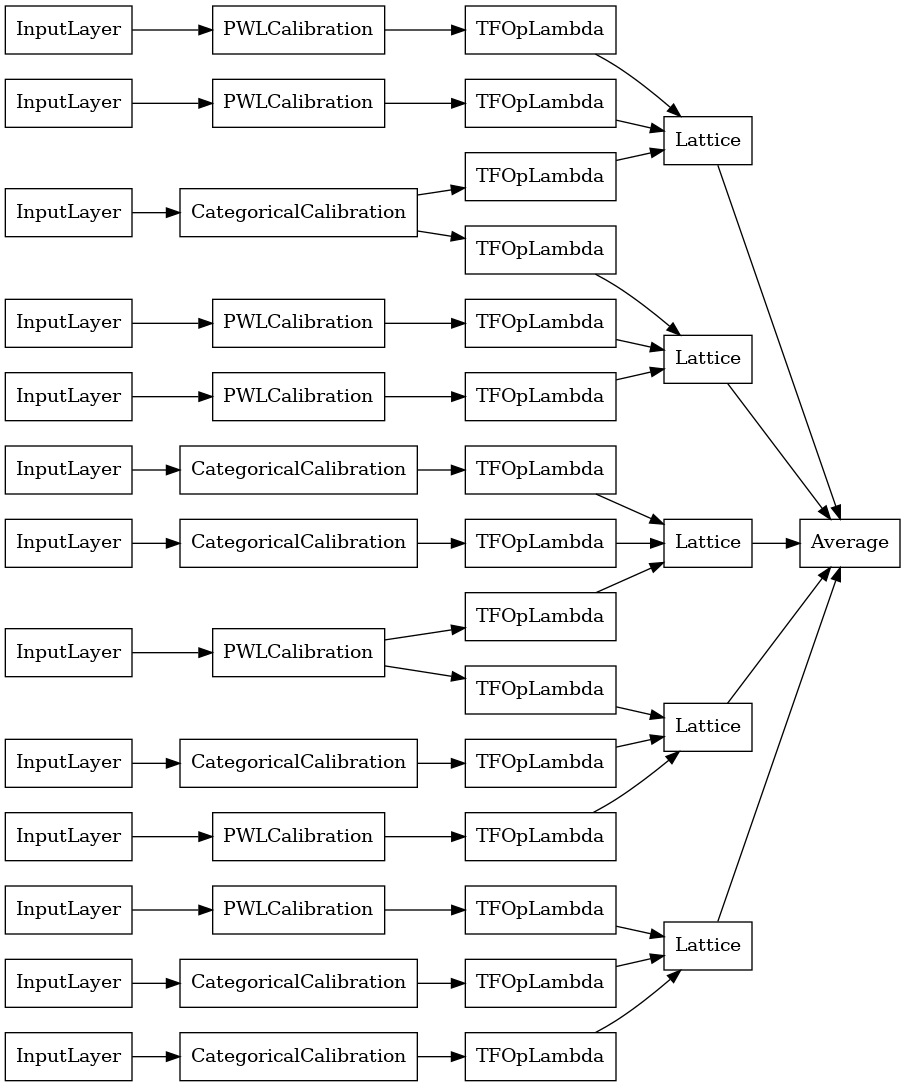

In [17]:
# This is a calibrated lattice ensemble model: inputs are calibrated, then
# combined non-linearly and averaged using multiple lattice layers.
random_ensemble_model_config = tfl.configs.CalibratedLatticeEnsembleConfig(
    feature_configs=heart_feature_configs,
    lattices='random',
    num_lattices=5,
    lattice_rank=3,
    # We initialize the output to [-2.0, 2.0] since we'll be using logits.
    output_initialization=[-2.0, 2.0],
    random_seed=42)
# Now we must set the random lattice structure and construct the model.
tfl.premade_lib.set_random_lattice_ensemble(random_ensemble_model_config)
# A CalibratedLatticeEnsemble premade model constructed from the given
# model config.
random_ensemble_model = tfl.premade.CalibratedLatticeEnsemble(
    random_ensemble_model_config)
# Let's plot our model.
keras.utils.plot_model(
    random_ensemble_model, show_layer_names=False, rankdir='LR')

As before, we compile, fit, and evaluate our model.

In [18]:
random_ensemble_model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.AUC(from_logits=True)],
    optimizer=keras.optimizers.Adam(LEARNING_RATE))
random_ensemble_model.fit(
    heart_train_xs,
    heart_train_ys,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=False)
print('Test Set Evaluation...')
print(random_ensemble_model.evaluate(heart_test_xs, heart_test_ys))

Test Set Evaluation...


1/2 [==============>...............] - ETA: 0s - loss: 0.3719 - auc_3: 0.8173

2/2 [==============================] - 1s 6ms/step - loss: 0.3800 - auc_3: 0.8966


[0.37996381521224976, 0.8966165781021118]


### RTL Layer Random Lattice Ensemble

When using a random lattice ensemble, you can specify that the model use a single `tfl.layers.RTL` layer. We note that `tfl.layers.RTL` only supports monotonicity constraints and must have the same lattice size for all features and no per-feature regularization. Note that using a `tfl.layers.RTL` layer lets you scale to much larger ensembles than using separate `tfl.layers.Lattice` instances.

This example creates a calibrated lattice ensemble model with 5 lattices and 3 features per lattice.

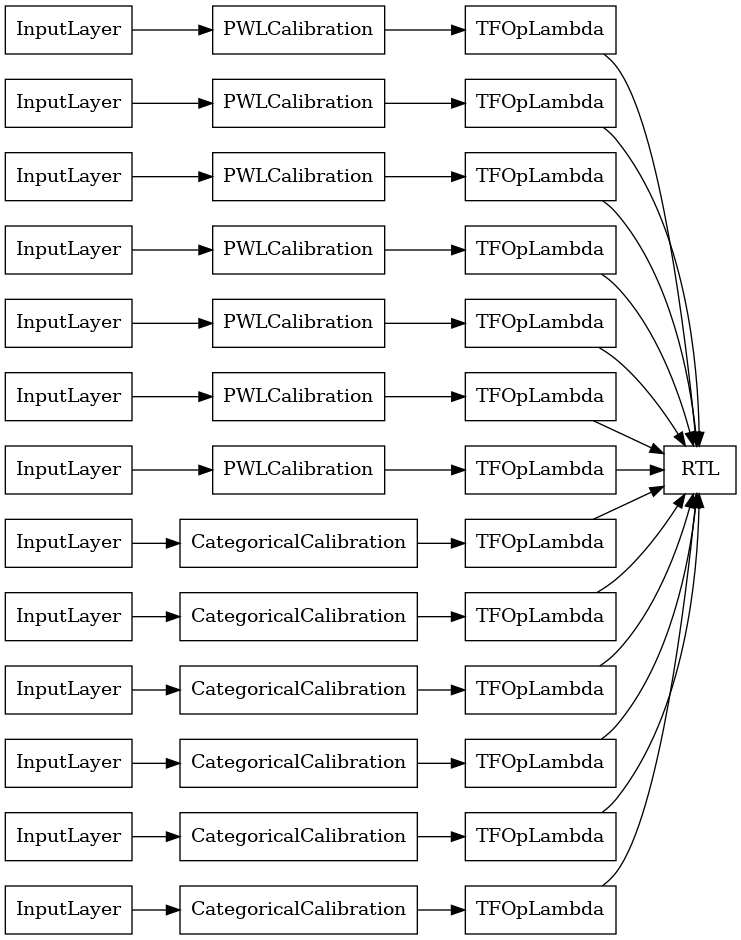

In [19]:
# Make sure our feature configs have the same lattice size, no per-feature
# regularization, and only monotonicity constraints.
rtl_layer_feature_configs = copy.deepcopy(heart_feature_configs)
for feature_config in rtl_layer_feature_configs:
  feature_config.lattice_size = 2
  feature_config.unimodality = 'none'
  feature_config.reflects_trust_in = None
  feature_config.dominates = None
  feature_config.regularizer_configs = None
# This is a calibrated lattice ensemble model: inputs are calibrated, then
# combined non-linearly and averaged using multiple lattice layers.
rtl_layer_ensemble_model_config = tfl.configs.CalibratedLatticeEnsembleConfig(
    feature_configs=rtl_layer_feature_configs,
    lattices='rtl_layer',
    num_lattices=5,
    lattice_rank=3,
    # We initialize the output to [-2.0, 2.0] since we'll be using logits.
    output_initialization=[-2.0, 2.0],
    random_seed=42)
# A CalibratedLatticeEnsemble premade model constructed from the given
# model config. Note that we do not have to specify the lattices by calling
# a helper function (like before with random) because the RTL Layer will take
# care of that for us.
rtl_layer_ensemble_model = tfl.premade.CalibratedLatticeEnsemble(
    rtl_layer_ensemble_model_config)
# Let's plot our model.
keras.utils.plot_model(
    rtl_layer_ensemble_model, show_layer_names=False, rankdir='LR')

As before, we compile, fit, and evaluate our model.

In [20]:
rtl_layer_ensemble_model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.AUC(from_logits=True)],
    optimizer=keras.optimizers.Adam(LEARNING_RATE))
rtl_layer_ensemble_model.fit(
    heart_train_xs,
    heart_train_ys,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=False)
print('Test Set Evaluation...')
print(rtl_layer_ensemble_model.evaluate(heart_test_xs, heart_test_ys))

Test Set Evaluation...


1/2 [==============>...............] - ETA: 0s - loss: 0.3474 - auc_4: 0.8622

2/2 [==============================] - 0s 7ms/step - loss: 0.3596 - auc_4: 0.9079


[0.35961830615997314, 0.9078947305679321]


### Crystals Lattice Ensemble

Premade also provides a heuristic feature arrangement algorithm, called [Crystals](https://papers.nips.cc/paper/6377-fast-and-flexible-monotonic-functions-with-ensembles-of-lattices). To use the Crystals algorithm, first we train a prefitting model that estimates pairwise feature interactions. We then arrange the final ensemble such that features with more non-linear interactions are in the same lattices.

the Premade Library offers helper functions for constructing the prefitting model configuration and extracting the crystals structure. Note that the prefitting model does not need to be fully trained, so a few epochs should be enough.

This example creates a calibrated lattice ensemble model with 5 lattice and 3 features per lattice.

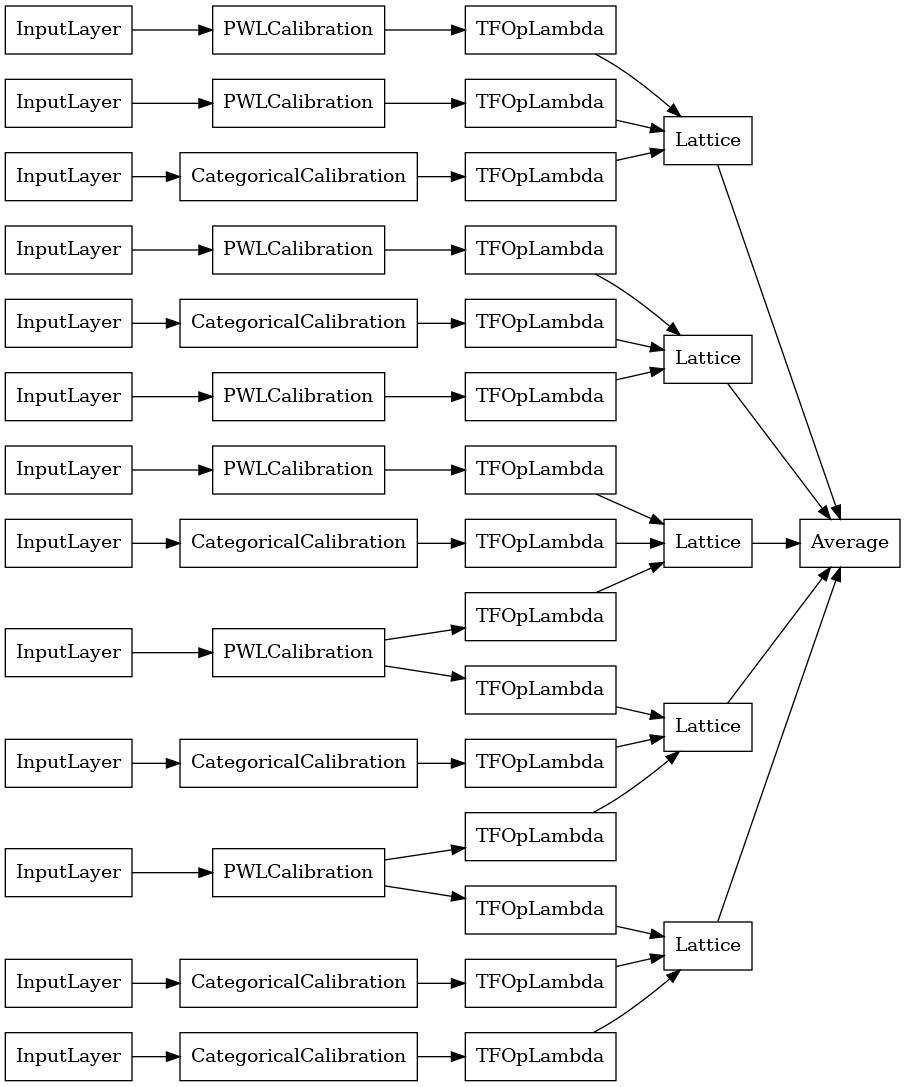

In [21]:
# This is a calibrated lattice ensemble model: inputs are calibrated, then
# combines non-linearly and averaged using multiple lattice layers.
crystals_ensemble_model_config = tfl.configs.CalibratedLatticeEnsembleConfig(
    feature_configs=heart_feature_configs,
    lattices='crystals',
    num_lattices=5,
    lattice_rank=3,
    # We initialize the output to [-2.0, 2.0] since we'll be using logits.
    output_initialization=[-2.0, 2.0],
    random_seed=42)
# Now that we have our model config, we can construct a prefitting model config.
prefitting_model_config = tfl.premade_lib.construct_prefitting_model_config(
    crystals_ensemble_model_config)
# A CalibratedLatticeEnsemble premade model constructed from the given
# prefitting model config.
prefitting_model = tfl.premade.CalibratedLatticeEnsemble(
    prefitting_model_config)
# We can compile and train our prefitting model as we like.
prefitting_model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(LEARNING_RATE))
prefitting_model.fit(
    heart_train_xs,
    heart_train_ys,
    epochs=PREFITTING_NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=False)
# Now that we have our trained prefitting model, we can extract the crystals.
tfl.premade_lib.set_crystals_lattice_ensemble(crystals_ensemble_model_config,
                                              prefitting_model_config,
                                              prefitting_model)
# A CalibratedLatticeEnsemble premade model constructed from the given
# model config.
crystals_ensemble_model = tfl.premade.CalibratedLatticeEnsemble(
    crystals_ensemble_model_config)
# Let's plot our model.
keras.utils.plot_model(
    crystals_ensemble_model, show_layer_names=False, rankdir='LR')

As before, we compile, fit, and evaluate our model.

In [22]:
crystals_ensemble_model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.AUC(from_logits=True)],
    optimizer=keras.optimizers.Adam(LEARNING_RATE))
crystals_ensemble_model.fit(
    heart_train_xs,
    heart_train_ys,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=False)
print('Test Set Evaluation...')
print(crystals_ensemble_model.evaluate(heart_test_xs, heart_test_ys))

Test Set Evaluation...


1/2 [==============>...............] - ETA: 0s - loss: 0.4178 - auc_5: 0.7885

2/2 [==============================] - 1s 7ms/step - loss: 0.3905 - auc_5: 0.8904


[0.39049428701400757, 0.890350878238678]
